<a href="https://colab.research.google.com/github/MarkStephens060482/WildFires/blob/master/Wildfire_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predictive modelling of Wildfires

A dataset based on Remote Sensing data related to the state of the crops (NDVI), meteorological conditions (LST), as well as the fire indicator “Thermal Anomalies”, these data, were acquired from “MODIS” (Moderate Resolution Imaging Spectroradiometer), a key instrument aboard the Terra and Aqua satellites. This dataset is available on GitHub via this link (https://github.com/ouladsayadyounes/Wildfires). The study area is composed of multiple zones located in the center of Canada.

The Dataset:

|Variables| Description|Type|
|:-------:|:----------:|:--:|
|NDVI| Normalised Difference Vegetation Index: indicates the state of crop health, it can be used to assess spatiotemporal changes in green vegetation.| *Float*|
|LST| Land Surface Temperature: represents the radiative skin temperature of land surface derived from solar radiation, depends on vegetation cover and th soi moisture.| Float|
|Burned_Area|


In [20]:
# importing libraries
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt

In [21]:
#loadiong the dataset from GitHub
url = "https://raw.githubusercontent.com/MarkStephens060482/WildFires/master/WildFires_DataSet.csv"
data = pd.read_csv(url)

In [22]:
data.head()

,NDVI,LST,BURNED_AREA,CLASS
0,0.506782,14584.272727,4.692308,no_fire
1,0.522150,14655.833333,5.000000,no_fire
2,0.682284,14780.000000,5.000000,fire
3,0.120046,13298.500000,3.500000,no_fire
4,0.568734,14743.000000,5.000000,no_fire


### Pairplot
The numerical variables considered as possible predictors are examined, excluding *NDVI*, *LST* and *BURNED_AREA*. 

Text(0.5, 1.03, 'Pair plot of numerical predictors')

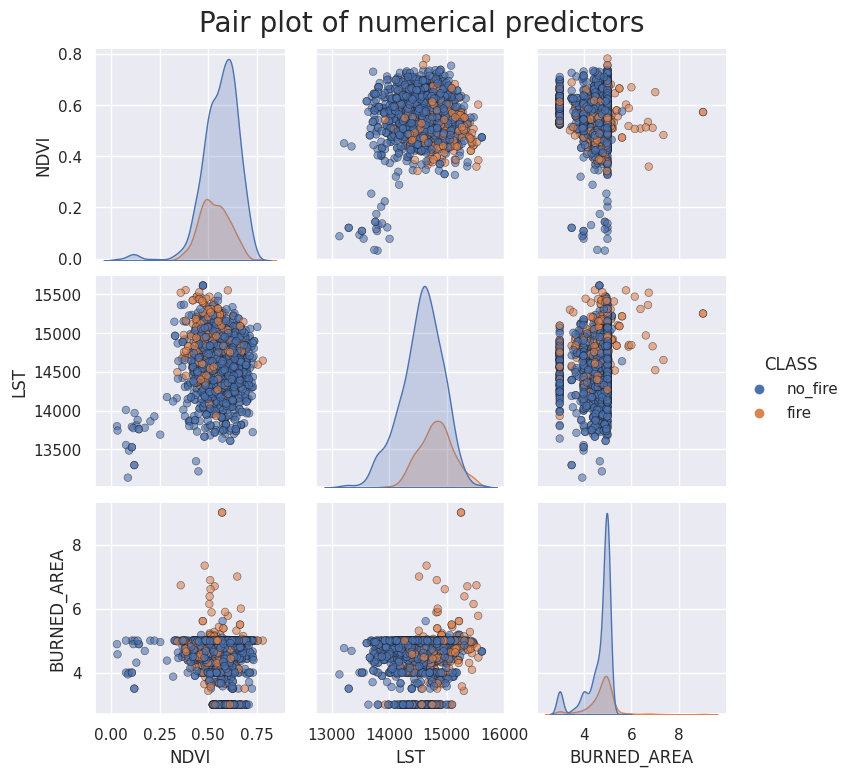

In [24]:
sns.pairplot(data,
             hue='CLASS',
             diag_kind = 'kde',
             plot_kws = {'alpha': 0.6, 's': 30, 'edgecolor': 'k'}
             )         
  # Title 
plt.suptitle(f'Pair plot of numerical predictors',
             size = 20,
             y=1.03)         

<Figure size 1400x1400 with 0 Axes>

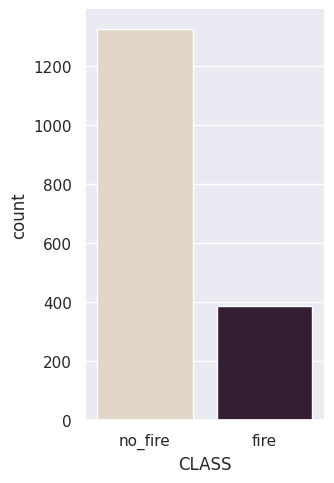

In [25]:
# set plot style: grey grid in the background:
sns.set(style="darkgrid")

# set the figure size
plt.figure(figsize=(14, 14))
sns.catplot(data=data, x="CLASS", kind="count", palette="ch:.25",aspect=.7)

### Preprocessing 
The data is normalised and a preprocessing step is defined in a pipeline. The categorical target variable is encoded. 

In [26]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder

# Target encoding
le = LabelEncoder()

# Transform Target variable by encoding
le.fit_transform(data['CLASS'])

# define a minmax scaler to normalise minmax
minmax = MinMaxScaler()

# Create a pipeline for data preprocessing
preprocessor = make_pipeline(minmax)

Classification models used in ensemble model for wildfire classification using scikit-learn library.
- Random Forest Classifier
- Naive Bayes Classifier
- Support Vector Machine Classifier
- Multilayer Perceptron  Classifier
- Gradient Boosting Classifier

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier

#create individual models
rf = RandomForestClassifier(n_estimators=100, random_state=42,class_weight = 'balanced')
nb = GaussianNB()
svc = SVC(kernel = "rbf",random_state=42,class_weight = 'balanced',probability =  True)
mlp = MLPClassifier(random_state=42)
gbc = GradientBoostingClassifier(random_state=42)
knn = KNeighborsClassifier()
adbc = AdaBoostClassifier()

#### Dummy Regressor
Use a 'mean' strategy to establish a baseline for model performance.

In [29]:
from sklearn.dummy import DummyClassifier
# initiialise the dummy regressor
dummy = DummyClassifier(strategy='prior')

# list of base learners
models = [dummy,rf,nb,svc,mlp,gbc,knn,adbc]

### Data Segregation
The data is split into 80%/20% train and test sets, stratified by the proportion of classes.  

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold

#model predictors
X = data.drop('CLASS', axis=1) 

#target variable
y = data['CLASS']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify = y)

new_line = '\n'
print(f'Training dataset:{new_line}\
X_train = { X_train.shape} {new_line}\
y_train = { y_train.shape}{new_line}')

print(f'Testing dataset:{new_line}\
X_test = {X_test.shape}{new_line}\
y_test = {y_test.shape}')

n_splits = 5
n_repeats = 3

# Cross - validation strategy
CVsplitter = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats = n_repeats,random_state = 42)
#cross-validation gridsearch
CVsplitter_grid = StratifiedKFold(n_splits = n_splits,shuffle = True,random_state = 42)


Training dataset:
X_train = (1456, 3) 
y_train = (1456,)

Testing dataset:
X_test = (257, 3)
y_test = (257,)


***
### Model fitting and Hyper parameter tuning
Both the untuned and tuned models are to be evaluated using cross validation. The models are looped through and the mean value and standard error of the scoring metrics of accuracy are determined under cross-validation.

In [31]:
from sklearn.model_selection import cross_validate

# define of estimators including the dummy regressor

metrics = ['accuracy', 'roc_auc']

model_scores = {}
# loop over the model pipelines
for model in models:
  pipeline = make_pipeline(preprocessor,model)

  # perform cross validation to get cv performance scores
  cv_results = cross_validate(pipeline,X_train,
                              y_train,
                              scoring =metrics,
                              cv = CVsplitter,
                              n_jobs=-1,                                   
                              verbose = 3)
  
  scores = []
  for metric in metrics:

    # determine mean, standard deviation and standard error of cv performance metric
    metric_mean = cv_results['test_' + metric].mean() 
    metric_stdev = cv_results['test_'+ metric].std() 
    metric_sterr = metric_stdev/np.sqrt(n_splits*n_repeats)

    # mean cross validationm scores with error
    metric_result = f'{metric_mean: .3f} \u00B1 {2*metric_sterr: .3f}'

    scores.append(metric_result)

  # append model name and cv score to list
  model_scores[pipeline.steps[1][0]] = scores
  
# express as a Data Frame
results_df = pd.DataFrame(model_scores,
                          index = ['accuracy','ROC_AUC'])
results_df

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    5.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    4.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    6.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    4.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15

,dummyclassifier,randomforestclassifier,gaussiannb,svc,mlpclassifier,gradientboostingclassifier,kneighborsclassifier,adaboostclassifier
accuracy,0.775 ± 0.001,0.824 ± 0.010,0.777 ± 0.004,0.632 ± 0.014,0.781 ± 0.007,0.798 ± 0.007,0.769 ± 0.012,0.788 ± 0.004
ROC_AUC,0.500 ± 0.000,0.806 ± 0.017,0.718 ± 0.020,0.729 ± 0.018,0.725 ± 0.017,0.773 ± 0.015,0.711 ± 0.015,0.748 ± 0.013


#### Hyper parameter tuning
The hyper parameters of each model are tuned using a hybrid approach of Randomised Search and Grid Search cross validation. The Randomised search identifies a ball park value for the optimum hyper parameter, while the grid seach will conduct a finer search within a range of some percentage either side of the value. 

#### Randomised Search

In [36]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import uniform
from random import sample
import numpy as np
import pickle

#defining the hyperparameter space ranges

# Support Vector Machine Classifier
# Examining verbose suggests that C >20 fails to converge.
C_range = np.logspace(-2,1,1000)
gamma_range = np.logspace(-2, 0.1, 1000)
degree_range = [2,3,4,5]
kernel_range = ['rbf','sigmoid','poly']
# Random Forest Classifier parameters
n_estimators_range = sample(range(50, 400), 300)
max_depth_range = sample(range(2, 15), 13)
min_samples_split_range =  sample(range(2, 15), 13)
min_samples_leaf_range = sample(range(1, 15), 14)
max_features_range = [3]

#GaussianNB parameter ranges
var_smoothing_range = np.logspace(-11, -5, 10000)

#MLPClassifier parameter ranges
alpha_range = np.logspace(-6, 0, 10000)

#Gradient Boosting parameter ranges
learning_rate_range = np.logspace(-4,1,10000)

#AdaBoost Classifier parameters
random_param_adbc = {'adaboostclassifier__n_estimators':n_estimators_range,
                     'adaboostclassifier__learning_rate': learning_rate_range}

#KNN parameters
random_param_knn = {'kneighborsclassifier__n_neighbors': sample(range(1,31),30),
                    'kneighborsclassifier__weights':['uniform', 'distance']}             
    
#SVC parameters
random_param_svc = {'svc__C' : C_range,
                    'svc__degree': degree_range,
                    'svc__kernel':kernel_range,
                    'svc__gamma' : gamma_range}

#RF parameters
random_param_rf = {'randomforestclassifier__n_estimators' : n_estimators_range,
                   'randomforestclassifier__max_depth': max_depth_range,
                   'randomforestclassifier__min_samples_split' : min_samples_split_range,
                   'randomforestclassifier__min_samples_leaf' : min_samples_leaf_range,
                   'randomforestclassifier__max_features' : max_features_range}

#GaussianNB parameters
random_param_nb = {'gaussiannb__var_smoothing' : var_smoothing_range}

#MLPClassifier parameters
random_param_mlpc = {'mlpclassifier__hidden_layer_sizes' : [(50,50),(100,100),(150,150),(200,200),(50,50,50),(100,100,100),(150,150,150)],
                     'mlpclassifier__activation' : ['identity', 'logistic', 'tanh', 'relu'],
                     'mlpclassifier__alpha' : alpha_range}

#GradientBoosting
random_param_gbc = {'gradientboostingclassifier__learning_rate': learning_rate_range,
                    'gradientboostingclassifier__n_estimators': n_estimators_range,
                    'gradientboostingclassifier__min_samples_split':min_samples_split_range,
                    'gradientboostingclassifier__min_samples_leaf':min_samples_leaf_range,
                    'gradientboostingclassifier__max_depth':max_depth_range}

# [dummy,rf,nb,rbfsvc,mlp,gbc]
random_param_dummy = {'dummyclassifier__strategy' : ['prior']}

# parameters
parameters = [random_param_dummy,
              random_param_rf,
              random_param_nb,
              random_param_svc,
              random_param_mlpc,
              random_param_gbc,
              random_param_knn,
              random_param_adbc]

# Conduct random search within the region of the optimal hyperparameters
tuned_models = {}

with open('models.pkl', 'wb') as handle1:

  for i,model in enumerate(models):
    pipeline = make_pipeline(preprocessor,model)
    random_grid = RandomizedSearchCV(pipeline,
                                     parameters[i],
                                     n_iter = 150,
                                     cv = CVsplitter_grid,
                                     scoring = metrics,
                                     refit='accuracy',
                                     n_jobs = -1,
                                     verbose=3)
    # fit the model
    random_grid.fit(X_train, y_train)

    # Get the best hyperparameters from the random search
    best_random = random_grid.best_params_

    new_line = '\n'
    print(f'{random_grid.estimator} has best hyper parameters for Randomised search are: {new_line}\
    {best_random}')

    tuned_models[pipeline.steps[1][0]] = best_random
    
    # Save models
    pickle.dump(random_grid, handle1,pickle.HIGHEST_PROTOCOL)

with open('best_params_random_search.pkl', 'wb') as handle2:
  pickle.dump(tuned_models, handle2, protocol=pickle.HIGHEST_PROTOCOL)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=150. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('minmaxscaler', MinMaxScaler())])),
                ('dummyclassifier', DummyClassifier())]) has best hyper parameters for Randomised search are: 
    {'dummyclassifier__strategy': 'prior'}
Fitting 5 folds for each of 150 candidates, totalling 750 fits
Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('minmaxscaler', MinMaxScaler())])),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))]) has best hyper parameters for Randomised search are: 
    {'randomforestclassifier__n_estimators': 109, 'randomforestclassifier__min_samples_split': 4, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__max_features': 3, 'randomforestclassifier__max_depth': 13}
Fitting 5 folds for each of 150 candidates, totalling 750 fits
Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('minmaxs

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 60 is smaller than n_iter=150. Running 60 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('minmaxscaler', MinMaxScaler())])),
                ('kneighborsclassifier', KNeighborsClassifier())]) has best hyper parameters for Randomised search are: 
    {'kneighborsclassifier__weights': 'distance', 'kneighborsclassifier__n_neighbors': 29}
Fitting 5 folds for each of 150 candidates, totalling 750 fits
Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('minmaxscaler', MinMaxScaler())])),
                ('adaboostclassifier', AdaBoostClassifier())]) has best hyper parameters for Randomised search are: 
    {'adaboostclassifier__n_estimators': 396, 'adaboostclassifier__learning_rate': 0.05838168531096668}


### Gridsearch hyperparameter tunning
Using the best parameters from the Randomised search tuning, a further grid search is conducted to find the most optimal values. The grid search range of hyper parameter values is define with a width proportion, *wp*, either side of the best value identified from the randomised search. The number of values in the grid search is defined as the given parameter *n*.


In [42]:
# proportion of width
wp = 0.2
# number of values
n = 10

#defining the hyperparameter space ranges
best_params = pickle.load(open('best_params_random_search.pkl', 'rb'))

# Support Vector Machine Classifier
C_range = best_params['svc']['svc__C']*(1 + np.arange(-wp, wp, 2*wp/(n-1)))
gamma_range = best_params['svc']['svc__gamma']*(1 + np.arange(-wp, wp, 2*wp/(n-1)))
degree_range = [best_params['svc']['svc__degree']]
kernel_range = [best_params['svc']['svc__kernel']]

# Random Forest Classifier parameters
n_estimators_range = best_params['randomforestclassifier']['randomforestclassifier__n_estimators'] + np.arange(-10, 10, 5)
max_depth_range = best_params['randomforestclassifier']['randomforestclassifier__max_depth'] + np.arange(-2,2,1)
min_samples_split_range =  best_params['randomforestclassifier']['randomforestclassifier__min_samples_split'] + np.arange(-1,2,1)
min_samples_leaf_range = best_params['randomforestclassifier']['randomforestclassifier__min_samples_leaf'] + np.arange(0,2,1)
max_features_range = [best_params['randomforestclassifier']['randomforestclassifier__max_features']]

#GaussianNB parameter ranges
var_smoothing_range = best_params['gaussiannb']['gaussiannb__var_smoothing']*(1 + np.arange(-wp, wp, 2*wp/(n-1)))

#MLPClassifier parameter ranges
alpha_range = best_params['mlpclassifier']['mlpclassifier__alpha']*(1 + np.arange(-wp, wp, 2*wp/(n-1)))
hidden_layer_sizes_range = [best_params['mlpclassifier']['mlpclassifier__hidden_layer_sizes']]
activation_range = [best_params['mlpclassifier']['mlpclassifier__activation']]

#Gradient Boosting parameter and AdaBoost Classifier ranges
learning_rate_range = best_params['gradientboostingclassifier']['gradientboostingclassifier__learning_rate']*(1 + np.arange(-wp, wp, 2*wp/(n-1)))

#K-Nearest Neighbour Classifier
n_neighbors_range = best_params['kneighborsclassifier']['kneighborsclassifier__n_neighbors'] + np.arange(-5,5,1)
weights_range = [best_params['kneighborsclassifier']['kneighborsclassifier__weights']]

#AdaBoost Classifier parameters
gridsearch_param_adbc = {'adaboostclassifier__n_estimators':n_estimators_range,
                         'adaboostclassifier__learning_rate': learning_rate_range}

#KNN parameters
gridsearch_param_knn = {'kneighborsclassifier__n_neighbors': n_neighbors_range,
                        'kneighborsclassifier__weights': weights_range}             
    
#SVC parameters
gridsearch_param_svc = {'svc__C' : C_range,
                        'svc__degree': degree_range,
                        'svc__kernel':kernel_range,
                        'svc__gamma' : gamma_range}

#RF parameters
gridsearch_param_rf = {'randomforestclassifier__n_estimators' : n_estimators_range,
                       'randomforestclassifier__max_depth': max_depth_range,
                       'randomforestclassifier__min_samples_split' : min_samples_split_range,
                       'randomforestclassifier__min_samples_leaf' : min_samples_leaf_range,
                       'randomforestclassifier__max_features' : max_features_range}

#GaussianNB parameters
gridsearch_param_nb = {'gaussiannb__var_smoothing' : var_smoothing_range}

#MLPClassifier parameters
gridsearch_param_mlpc = {'mlpclassifier__hidden_layer_sizes' : hidden_layer_sizes_range,
                         'mlpclassifier__activation' : activation_range,
                         'mlpclassifier__alpha' : alpha_range}

#GradientBoosting
gridsearch_param_gbc = {'gradientboostingclassifier__learning_rate': learning_rate_range,
                        'gradientboostingclassifier__n_estimators': n_estimators_range,
                        'gradientboostingclassifier__min_samples_split':min_samples_split_range,
                        'gradientboostingclassifier__min_samples_leaf':min_samples_leaf_range,
                        'gradientboostingclassifier__max_depth':max_depth_range}

# [dummy,rf,nb,rbfsvc,mlp,gbc]
gridsearch_param_dummy = {'dummyclassifier__strategy' : ['prior']}

# parameters
parameters2 = [gridsearch_param_dummy,
               gridsearch_param_rf,
               gridsearch_param_nb,
               gridsearch_param_svc,
               gridsearch_param_mlpc,
               gridsearch_param_gbc,
               gridsearch_param_knn,
               gridsearch_param_adbc]

with open('models_final.pkl', 'wb') as handle3:

  for i,model in enumerate(models):
    pipeline = make_pipeline(preprocessor,model)
    gridsearch = GridSearchCV(pipeline,
                               parameters2[i],
                               cv = CVsplitter_grid,
                               scoring = metrics,
                               refit='accuracy',
                               n_jobs = -1,
                               verbose=3)
    
    # fit the model
    gridsearch.fit(X_train, y_train)

    # Save final models
    pickle.dump(gridsearch, handle3,pickle.HIGHEST_PROTOCOL)



Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 864 candidates, totalling 4320 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits


### Tuning ensemble classifier by learner weights using cross-validation accuracy of tuned individual learners as weights ratio.
The weights of the 'soft' voting ensemble Classifier are determined by the ratio of cross validation accuracy scores of individual learners. The weights for each base learner model $m_{i}$ is given by $w_{i} = {A_{i}\over ΣA_{i}}$, where $A_{i}$ is the cross-validation accuracy score for base learner $m_{i}$. The ratio of weights $R_{W}$ is given by $A_{1}:A_{2}:...:A_{n}$ $∀  m_{i} ϵ M$ learners. The $R_{W}$ is determined for the *weights* parameter for the ensemble classifier.



In [49]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier

learner_weights = []
learner_ensemble = []
final_models = []
with open('models_final.pkl', 'rb') as handle3:
  while True:
    try:
      final_models.append(pickle.load(handle3))
    except EOFError:
      break

for i,model in enumerate(final_models):
  # load the model from disk
  if i == 0:
    dummy = model  
    
  #retrieve CV score stats for model
  mean_acc = model.best_score_
  stdev_acc = model.cv_results_['std_test_accuracy'][model.best_index_]
  sterr_acc = stdev_acc/np.sqrt(n_splits)
  # mean cross validation scores with error
  metric_result = f'{mean_acc: .3f} \u00B1 {2*sterr_acc: .3f}'
  print(f'{model.estimator.steps[1][0]} has CV accuracy {metric_result}')
  tol = 0.01
  if mean_acc > (dummy.best_score_ + tol):
    learner_weights.append(mean_acc)
    learner_ensemble.append((str(model.estimator.steps[1][0]),model))

# Ensemble classifier 1 - 
ensemble_model1 = VotingClassifier(learner_ensemble,
                                   voting = 'soft',
                                   n_jobs = -1,
                                   weights=learner_weights,
                                   verbose = 3)

#fit the ensemble model1 
ensemble_model1.fit(X_train,y_train)

#Take the best classifier from the ensemble
best_classifier = learner_ensemble.pop(learner_weights.index(max(learner_weights)))

#Ensemble classifier 2 - Stack of estimators with a final classifier.
clf = StackingClassifier(estimators=learner_ensemble,
                         final_estimator = best_classifier,
                         n_jobs = -1,
                         cv = "prefit")

#pred_y = ensemble_model.predict(X_test)

dummyclassifier has CV accuracy  0.775 ±  0.001
randomforestclassifier has CV accuracy  0.818 ±  0.016
gaussiannb has CV accuracy  0.779 ±  0.009
svc has CV accuracy  0.556 ±  0.241
mlpclassifier has CV accuracy  0.791 ±  0.015
gradientboostingclassifier has CV accuracy  0.802 ±  0.013
kneighborsclassifier has CV accuracy  0.819 ±  0.015
adaboostclassifier has CV accuracy  0.775 ±  0.001
Fitting 5 folds for each of 96 candidates, totalling 480 fits


KeyboardInterrupt: ignored

In [45]:
  learner_ensemble

[]